In [1]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 4.3 MB/s 


In [ ]:
!unzip "/content/drive/MyDrive/display.zip" -d "/content/brain tumor"

In [3]:
from pathlib import Path
import numpy as np
import cv2
import pydicom
import matplotlib.pyplot as plt

DATASET = 'train'
scan_types = ['FLAIR','T1w','T1wCE','T2w']
data_root = Path("/content/brain tumor")

In [4]:
def get_image_plane(data):
    x1, y1, _, x2, y2, _ = [round(j) for j in data.ImageOrientationPatient]
    cords = [x1, y1, x2, y2]

    if cords == [1, 0, 0, 0]:
        return 'Coronal'
    elif cords == [1, 0, 0, 1]:
        return 'Axial'
    elif cords == [0, 1, 0, 0]:
        return 'Sagittal'
    else:
        return 'Unknown'

In [5]:

position=[]

def get_voxel(study_id, scan_type):
    imgs = []
    dcm_dir = data_root.joinpath(DATASET, study_id, scan_type)
    dcm_paths = sorted(dcm_dir.glob("*.dcm"), key=lambda x: int(x.stem.split("-")[-1]))
    positions = []
    
    for dcm_path in dcm_paths:
        img = pydicom.dcmread(str(dcm_path))
        imgs.append(img.pixel_array)
        positions.append(img.ImagePositionPatient)
        
    plane = get_image_plane(img)
    voxel = np.stack(imgs)
    
    # reorder planes if needed and rotate voxel
    if plane == "Coronal":
        if positions[0][1] < positions[-1][1]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 0, 2))
    elif plane == "Sagittal":
        if positions[0][0] < positions[-1][0]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 2, 0))
        voxel = np.rot90(voxel, 2, axes=(1, 2))
    elif plane == "Axial":
        if positions[0][2] > positions[-1][2]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = np.rot90(voxel, 2)
    else:
        raise ValueError(f"Unknown plane {plane}")

    position=positions
    
    return voxel, plane

In [6]:
def normalize_contrast(voxel):
    if voxel.sum() == 0:
        return voxel
    voxel = voxel - np.min(voxel)
    voxel = voxel / np.max(voxel)
    voxel = (voxel * 255).astype(np.uint8)
    return voxel

In [7]:
def crop_voxel(voxel):
    if voxel.sum() == 0:
        return voxel
    keep = (voxel.mean(axis=(0, 1)) > 0)
    voxel = voxel[:, :, keep]
    keep = (voxel.mean(axis=(0, 2)) > 0)
    voxel = voxel[:, keep]
    keep = (voxel.mean(axis=(1, 2)) > 0)
    voxel = voxel[keep]
    return voxel

In [61]:
def resize_voxel(voxel, sz=128):
    output = np.zeros((sz, sz, sz), dtype=np.uint8)

    if np.argmax(voxel.shape) == 0:
        for i, s in enumerate(np.linspace(0, voxel.shape[0] - 1, sz)):
            output[i] = cv2.resize(voxel[int(s)], (sz, sz))
    elif np.argmax(voxel.shape) == 1:
        for i, s in enumerate(np.linspace(0, voxel.shape[1] - 1, sz)):
            output[:, i] = cv2.resize(voxel[:, int(s)], (sz, sz))
    elif np.argmax(voxel.shape) == 2:
        for i, s in enumerate(np.linspace(0, voxel.shape[2] - 1, sz)):
            output[:, :, i] = cv2.resize(voxel[:, :, int(s)], (sz, sz))

    return output

In [9]:
for study_path in list(data_root.joinpath(DATASET).glob("*"))[:2]:
    study_id = study_path.name
    
    if not study_path.is_dir():
        continue

    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(f"study id: {study_id}", fontsize=24)

    for i, scan_type in enumerate(scan_types):
        voxel, plane = get_voxel(study_id, scan_type)
        voxel = normalize_contrast(voxel)
        voxel = crop_voxel(voxel)
        voxel = resize_voxel(voxel)
        ax = fig.add_subplot(3, 4, i + 1)
        ax.set_title(f"{scan_type}, {plane}")
        ax.imshow(voxel[voxel.shape[0] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 4)
        ax.imshow(voxel[:, voxel.shape[1] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 8)
        ax.imshow(voxel[:, :, voxel.shape[2] // 2], cmap='gray')
    
    fig.show()

In [62]:
# print(get_voxel("00011", "T1wCE")[1])
flair=get_voxel("00000", "FLAIR")[0]
flair = normalize_contrast(flair)
flair1 = crop_voxel(flair)
flair2 = resize_voxel(flair1)
print(flair.shape)
print(flair2.shape)

# output = cv2.resize(flair[:,40,:], (64, 64))

(512, 400, 512)
(128, 128, 128)


(-0.5, 255.5, 255.5, -0.5)

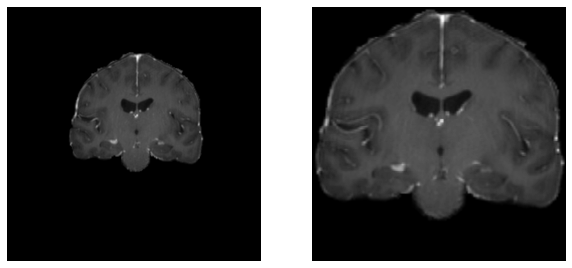

In [54]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(flair[:,60,:], cmap='gray')
ax.axis('off')
ax1 = fig.add_subplot(1, 2, 2)
ax1.imshow(flair2[:,128,:], cmap='gray')
ax1.axis('off')

In [ ]:
print(get_voxel("00000", "T1w")[1])
t1w=get_voxel("00000", "T1w")[0]
t1w = normalize_contrast(t1w)
t1w = crop_voxel(t1w)
t1w = resize_voxel(t1w)

Axial


In [ ]:
print(get_voxel("00000", "T1wCE")[1])
t1wce=get_voxel("00000", "T1wCE")[0]
t1wce = normalize_contrast(t1wce)
t1wce = crop_voxel(t1wce)
t1wce = resize_voxel(t1wce)

Coronal


In [ ]:
print(get_voxel("00000", "T2w")[1])
t2w=get_voxel("00000", "T2w")[0]
t2w = normalize_contrast(t2w)
t2w = crop_voxel(t2w)
t2w = resize_voxel(t2w)

Sagittal


In [ ]:
data=np.array((flair, t1w, t1wce, t2w))
data.shape

(4, 64, 64, 64)

In [ ]:
for i in range(4):
  rotate = np.random.randint(0,4)
  for j in range(64):
    rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
    data[i][j] = cv2.rotate(data[i][j], rot_choices[rotate])

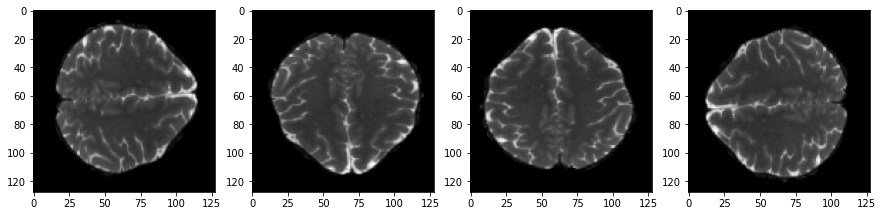

In [ ]:


fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(t2w[32], cmap='gray')
a1 = cv2.rotate(t2w[32], cv2.ROTATE_90_CLOCKWISE)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(a1, cmap='gray')
a2 = cv2.rotate(t2w[32], cv2.ROTATE_90_COUNTERCLOCKWISE)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(a2, cmap='gray')
a3 = cv2.rotate(t2w[32], cv2.ROTATE_180)
ax = fig.add_subplot(1, 4, 4)
ax.imshow(a3, cmap='gray')


In [ ]:
for i in range(64):
  rotate = np.random.randint(0,4)
  rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180, cv2]
  t2w[i] = cv2.rotate(t2w[i], rot_choices[rotate])

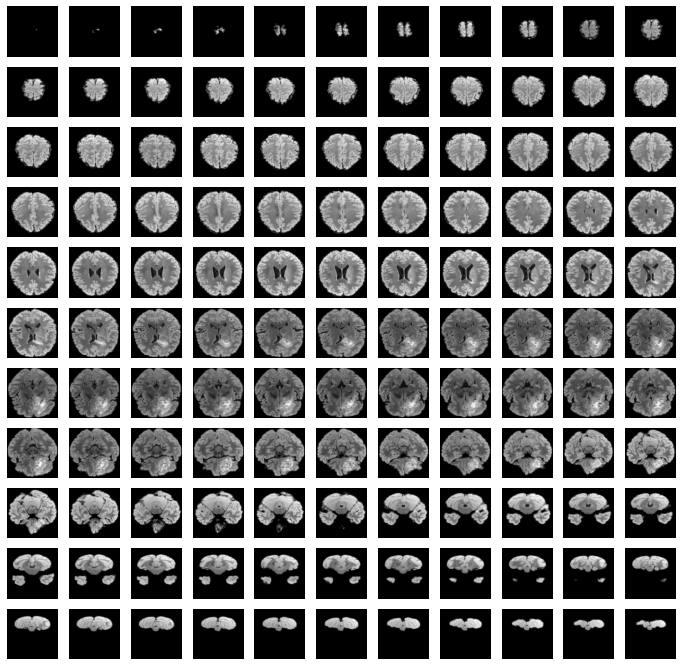

In [67]:
fig = plt.figure(figsize=(12, 12))
num=64
for i in range(121):
    ax = fig.add_subplot(11, 11, i+1)
    ax.axis('off')
    ax.imshow(flair2[i], cmap='gray')

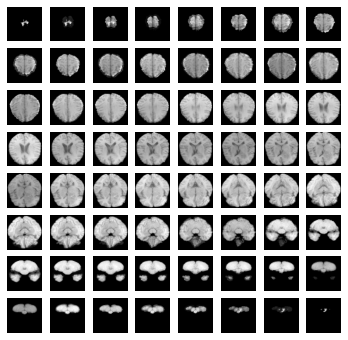

In [ ]:
fig = plt.figure(figsize=(6, 6))
num=64
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1)
    ax.axis('off')
    ax.imshow(data[0][i], cmap='gray')

In [ ]:
# fig = plt.figure(figsize=(6, 6))

# num=64
# for i in range(64):
#     ax = fig.add_subplot(8, 8, i+1)
#     ax.imshow(t1w[i], cmap='gray')

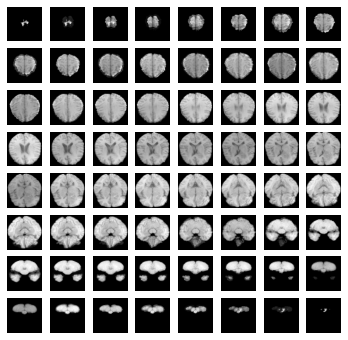

In [ ]:
fig = plt.figure(figsize=(6, 6))

num=64
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1)
    ax.axis('off')
    ax.imshow(data[1][i], cmap='gray')

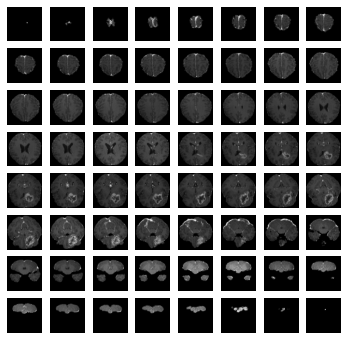

In [ ]:
fig = plt.figure(figsize=(6, 6))

num=64
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1)
    ax.axis('off')
    ax.imshow(data[2][i], cmap='gray')

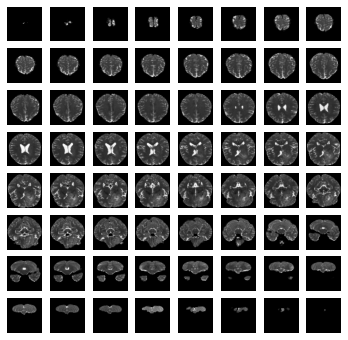

In [ ]:
fig = plt.figure(figsize=(6, 6))

num=64
for i in range(64):
    ax = fig.add_subplot(8, 8, i+1)
    ax.axis('off')
    
    ax.imshow(data[3][i], cmap='gray')

In [ ]:
import pandas as pd
import glob
train_df=pd.read_csv("/content/drive/MyDrive/brain tumor/train_labels.csv")
train_df

In [ ]:
data_path="/content/drive/MyDrive/brain tumor"

labels={}

id=list(train_df["BraTS21ID"])
value=list(train_df["MGMT_value"])
for i, j in zip(id, value):
  labels[str(i).zfill(5)]=j

idlist = sorted(glob.glob(f"{data_path}/train/*"))
ids=[i.split("/")[-1] for i in idlist]

In [ ]:
a=[
   [[1,2,0],
    [0,0,4],
    [2,2,0]],
   [[0,2,0],
    [1,2,0],
    [1,0,1]],
]
a.shape

AttributeError: ignored